In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Load dataset
df = pd.read_excel("Desktop/football project/Football_data_merged_cleaned_final.xlsx")  # replace with your file path
df.head()


,appearance_id,game_id,player_id_x,date_x,player_name_x,competition_id_x,yellow_cards,red_cards,goals,assists,...,away_club_position,home_club_manager_name,away_club_manager_name,stadium,attendance,referee,home_club_name,away_club_name,aggregate,competition_type
0,2224728_119169,2224728,119169,2012-07-13,Aron Johannsson,DK1,0,0,0,0,...,7,Peter Rensen,Kent Nielsen,Ceres Park,9728,Michael Svendsen,Aarhus Gymnastik Forening,Aalborg BK,01:01:00,domestic_league
1,2224732_161244,2224732,161244,2012-07-14,Conor O'Brien,DK1,0,0,1,0,...,12,Lars Sondergaard,Colin Todd,Sydbank Park,2995,Claus Bo Larsen,Sonderjyske Fc,Randers Fodbold Club,06:01:00,domestic_league
2,2224729_39467,2224729,39467,2012-07-15,Clarence Goodson,DK1,0,0,0,0,...,5,Auri Skarbalius,Troels Bech,Brondby Stadium,10806,Lars Christoffersen,Brondby IF,Odense Boldklub,00:01:00,domestic_league
3,2232104_119169,2232104,119169,2012-07-19,Aron Johannsson,ELQ,0,0,0,0,...,Unknown,Peter Rensen,Temur Shalamberidze,Ceres Park,9000,Boako Jovanetic,Aarhus Gymnastik Forening,Unknown,01:02:00,international_cup
4,2219794_39475,2219794,39475,2012-07-22,Sacha Kljestan,BESC,0,0,0,0,...,Unknown,John van den Brom,Peter Maes,Constant Vanden Stock Stadion,14485,Laurent Colemonts,Royal Sporting Club Anderlecht,KSC Lokeren (- 2020),03:02:00,other


In [3]:
# Convert date to datetime
df['date_x'] = pd.to_datetime(df['date_x'])

# Extract day of week
df['day_of_week'] = df['date_x'].dt.day_name()

# Total goals in a match
df['total_goals'] = df['home_club_goals'] + df['away_club_goals']

# Team popularity: average attendance per home team
team_popularity = df.groupby('home_club_name')['attendance'].mean().to_dict()
df['home_team_popularity'] = df['home_club_name'].map(team_popularity)

df[['stadium','attendance','day_of_week','home_team_popularity','total_goals']].head()


,stadium,attendance,day_of_week,home_team_popularity,total_goals
0,Ceres Park,9728,Friday,8088.552632,2.0
1,Sydbank Park,2995,Saturday,3429.833333,4.5
2,Brondby Stadium,10806,Sunday,11578.333333,1.0
3,Ceres Park,9000,Thursday,8088.552632,3.0
4,Constant Vanden Stock Stadion,14485,Sunday,19340.916667,5.0


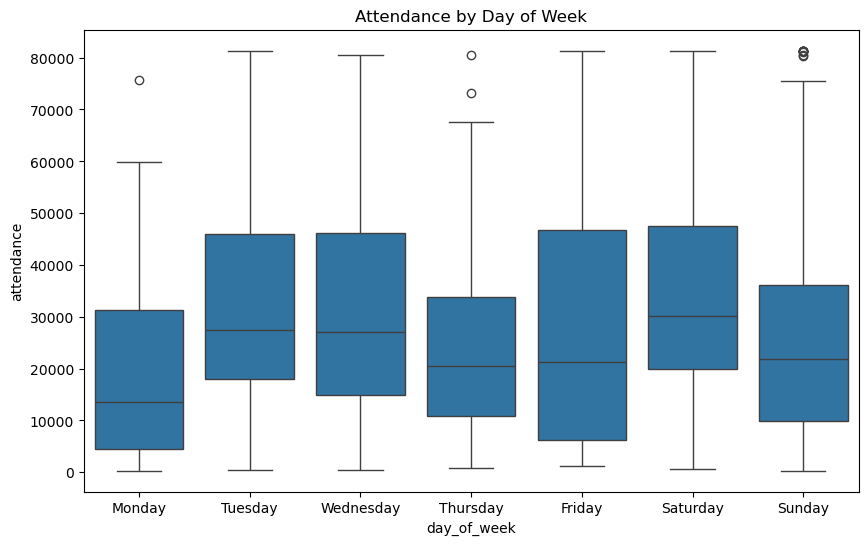

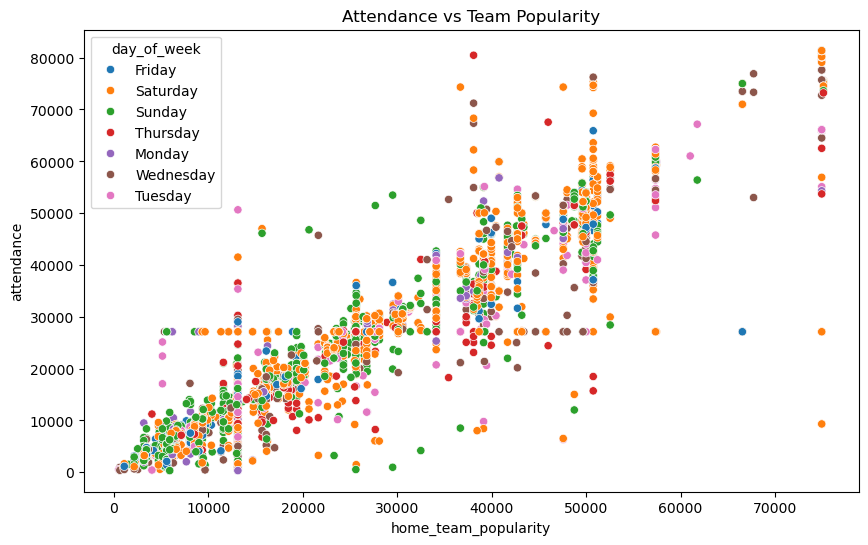

In [5]:
# Attendance by day of week
plt.figure(figsize=(10,6))
sns.boxplot(x='day_of_week', y='attendance', data=df,
            order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.title("Attendance by Day of Week")
plt.show()

# Attendance vs Home Team Popularity
plt.figure(figsize=(10,6))
sns.scatterplot(x='home_team_popularity', y='attendance', hue='day_of_week', data=df)
plt.title("Attendance vs Team Popularity")
plt.show()


In [7]:
# Attendance category
df['attendance_category'] = pd.qcut(df['attendance'], 3, labels=['Low','Medium','High'])

# Encode categorical features
le_stadium = LabelEncoder()
df['stadium_encoded'] = le_stadium.fit_transform(df['stadium'])
le_day = LabelEncoder()
df['day_encoded'] = le_day.fit_transform(df['day_of_week'])

# Features and target
X = df[['stadium_encoded','home_team_popularity','day_encoded']]
y = df['attendance_category']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# Evaluation
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[353   1  12]
 [  3 354  32]
 [ 59  35 294]]
              precision    recall  f1-score   support

        High       0.85      0.96      0.90       366
         Low       0.91      0.91      0.91       389
      Medium       0.87      0.76      0.81       388

    accuracy                           0.88      1143
   macro avg       0.88      0.88      0.87      1143
weighted avg       0.88      0.88      0.87      1143



Top 10 stadiums by average goals per game:
 stadium
Hermann-Neuberger-Stadion    8.5
MDCC-Arena                   8.5
Hacker Wiehenstadion         8.5
Erzgebirgsstadion            8.5
Jahnstadion Regensburg       8.5
Vodafone Park                8.5
SKI ARENA Wrocław            8.0
GP Stadion am Hardtwald      7.5
BUKO Stadion                 7.0
Fritz-Walter-Stadion         7.0
Name: total_goals, dtype: float64


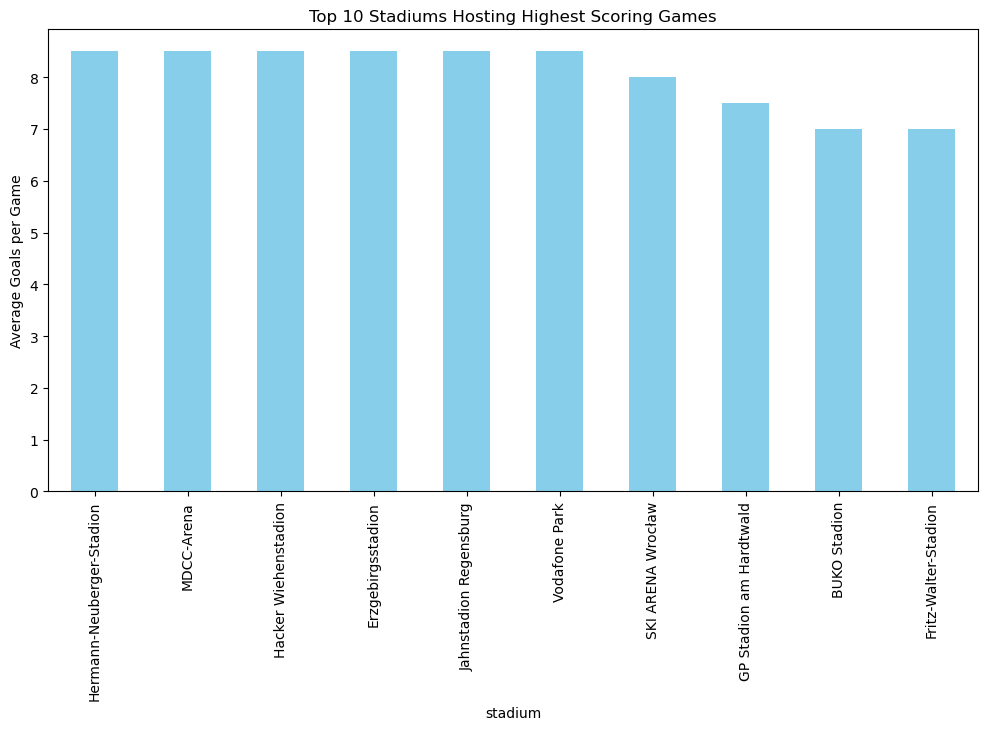

In [9]:
# Average goals per stadium
stadium_goals = df.groupby('stadium')['total_goals'].mean().sort_values(ascending=False)
print("Top 10 stadiums by average goals per game:\n", stadium_goals.head(10))

# Optional visualization
plt.figure(figsize=(12,6))
stadium_goals.head(10).plot(kind='bar', color='skyblue')
plt.ylabel("Average Goals per Game")
plt.title("Top 10 Stadiums Hosting Highest Scoring Games")
plt.show()
